<a href="https://colab.research.google.com/github/Brajesh31/fraud_qsvm/blob/main/fraud_qsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1.1 & 1.2: Installations and Imports

In [ ]:
!pip install qiskit -q
!pip install qiskit-machine-learning -q
!pip install qiskit-algorithms -q

In [ ]:
import pandas as np
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Quantum Imports
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute

print("All libraries imported successfully.")

All libraries imported successfully.


Import the csv siuccessful from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = np.read_csv('/content/drive/MyDrive/creditcard.csv')
print("File loaded successfully from Google Drive!")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully from Google Drive!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.38702

**The** Downsampling Method

In [ ]:
# Separate the original DataFrame into two classes
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Randomly select non-fraud samples to match the number of fraud samples
non_fraud_sampled = non_fraud.sample(n=len(fraud), random_state=42)

# Combine the fraud and the downsampled non-fraud samples
balanced_df = np.concat([fraud, non_fraud_sampled])

# Shuffle the new balanced DataFrame to mix the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset has been balanced using downsampling.")
print("New dataset shape:", balanced_df.shape)
print("\nClass distribution in the new dataset:")
print(balanced_df['Class'].value_counts())

Dataset has been balanced using downsampling.
New dataset shape: (984, 31)

Class distribution in the new dataset:
Class
0    492
1    492
Name: count, dtype: int64


**Standardize and Apply PCA**

In [ ]:
# Separate features (X) from the target (y) using the balanced_df
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Initialize the scaler and apply it to the 'Time' and 'Amount' columns
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Initialize PCA to reduce our 30 features down to 3
pca = PCA(n_components=3)

# Apply PCA to the dataset
X_pca = pca.fit_transform(X)

print("Standardization and PCA complete.")
print("The new shape of our feature set is:", X_pca.shape)

Standardization and PCA complete.
The new shape of our feature set is: (984, 3)


** Split Data**

In [ ]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print("Data splitting complete.")
print("Shape of training features (X_train):", X_train.shape)
print("Shape of testing features (X_test):", X_test.shape)

Data splitting complete.
Shape of training features (X_train): (787, 3)
Shape of testing features (X_test): (197, 3)


Create Feature Map, Kernel & Diagram

In [ ]:
# Define the quantum feature map for our 3 features
feature_map = ZZFeatureMap(feature_dimension=3, reps=1)

print("Quantum feature map created successfully. Here is the circuit diagram:")

# Draw the circuit diagram for your notebook
feature_map.draw()

Quantum feature map created successfully. Here is the circuit diagram:


┌───────────────────────────────┐
q_0: ┤0                              ├
     │                               │
q_1: ┤1 ZZFeatureMap(x[0],x[1],x[2]) ├
     │                               │
q_2: ┤2                              ├
     └───────────────────────────────┘

Quantum Kernal

In [ ]:
# Create the quantum kernel using the feature map we just made
quantum_kernel = FidelityStatevectorKernel(feature_map=feature_map)

print("Quantum kernel built successfully.")

Quantum kernel built successfully.


Compute Kernel Matrices (Ideal)

In [ ]:
# Compute the training kernel matrix
# This calculates the similarity between each pair of points in the training data.
print("Computing the training kernel matrix...")
matrix_train = quantum_kernel.evaluate(x_vec=X_train)
print("Training matrix computed.")

# Compute the testing kernel matrix
# This calculates the similarity between each test point and every training point.
print("\nComputing the testing kernel matrix...")
matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
print("Testing matrix computed.")

print("\nKernel matrix computation is complete.")

Computing the training kernel matrix...
Training matrix computed.

Computing the testing kernel matrix...
Testing matrix computed.

Kernel matrix computation is complete.


Train Ideal QSVM

In [ ]:
# Initialize the Support Vector Classifier and tell it to use our precomputed kernel
qsvm = SVC(kernel='precomputed', probability=True)

# Train the model using the quantum kernel training matrix and the training labels
print("Training the QSVM model...")
qsvm.fit(matrix_train, y_train)

print("QSVM model training complete.")

Training the QSVM model...
QSVM model training complete.


In [ ]:
# Use the trained model to make predictions on the test data
print("Making predictions on the test set...")
y_pred_qsvm = qsvm.predict(matrix_test)

# Print a detailed classification report
print("\n--- QSVM Performance Report ---")
print(classification_report(y_test, y_pred_qsvm))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, qsvm.predict_proba(matrix_test)[:,1])
print(f"ROC AUC Score: {roc_auc:.4f}")

Making predictions on the test set...

--- QSVM Performance Report ---
              precision    recall  f1-score   support

           0       0.80      0.77      0.78        99
           1       0.77      0.81      0.79        98

    accuracy                           0.79       197
   macro avg       0.79      0.79      0.79       197
weighted avg       0.79      0.79      0.79       197

ROC AUC Score: 0.8483


Train and Evaluate Classical SVM and Report

In [ ]:
# Initialize a classical SVM with an RBF kernel
classical_svm = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
print("Training the classical SVM model...")
classical_svm.fit(X_train, y_train)
print("Training complete.")

# Make predictions on the test set
print("\nMaking predictions...")
y_pred_classical = classical_svm.predict(X_test)

# Print a detailed classification report
print("\n--- Classical SVM Performance Report ---")
print(classification_report(y_test, y_pred_classical))

# Calculate and print the ROC AUC score
roc_auc_classical = roc_auc_score(y_test, classical_svm.predict_proba(X_test)[:,1])
print(f"ROC AUC Score: {roc_auc_classical:.4f}")

Training the classical SVM model...
Training complete.

Making predictions...

--- Classical SVM Performance Report ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        99
           1       0.99      0.83      0.90        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197

ROC AUC Score: 0.9718


Plot ROC Curve Comparison

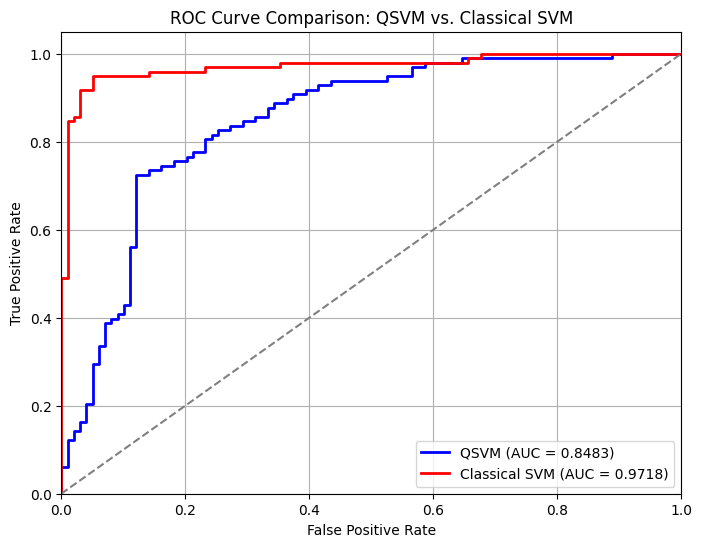

In [ ]:
# --- Calculate ROC curve data for both models ---
# Get prediction probabilities for the positive class (1)
y_scores_qsvm = qsvm.predict_proba(matrix_test)[:, 1]
y_scores_classical = classical_svm.predict_proba(X_test)[:, 1]

# Calculate the points for each curve
fpr_qsvm, tpr_qsvm, _ = roc_curve(y_test, y_scores_qsvm)
fpr_classical, tpr_classical, _ = roc_curve(y_test, y_scores_classical)

# --- Plot both curves ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_qsvm, tpr_qsvm, color='blue', lw=2, label=f'QSVM (AUC = {roc_auc:.4f})')
plt.plot(fpr_classical, tpr_classical, color='red', lw=2, label=f'Classical SVM (AUC = {roc_auc_classical:.4f})')

# --- Format the plot ---
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Dashed line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: QSVM vs. Classical SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# =======================================================
# Step 5: Error Analysis & Noise Impact (Corrected)
# =======================================================
print("--- Starting Noise Simulation (New Method) ---")

import numpy as np

# This custom function manually computes the noisy kernel matrix
def compute_noisy_kernel_matrix(X1, X2, feature_map):
    print(f"Calculating noisy matrix of size {len(X1)}x{len(X2)}...")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    matrix = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            # CORRECTED LINE: Use .assign_parameters instead of .bind_parameters
            circuit1 = feature_map.assign_parameters(x1)
            # CORRECTED LINE: Use .assign_parameters instead of .bind_parameters
            circuit2 = feature_map.assign_parameters(x2)

            result = fidelity.run([circuit1], [circuit2]).result()
            matrix[i, j] = result.fidelities[0]
    print("Calculation complete.")
    return matrix

# Re-compute kernel matrices with noise using our new function
matrix_train_noisy = compute_noisy_kernel_matrix(X_train, X_train, feature_map)
matrix_test_noisy = compute_noisy_kernel_matrix(X_test, X_train, feature_map)

# Train and evaluate the new noisy QSVM
qsvm_noisy = SVC(kernel='precomputed')
qsvm_noisy.fit(matrix_train_noisy, y_train)
y_pred_qsvm_noisy = qsvm_noisy.predict(matrix_test_noisy)

print("\n--- Noisy QSVM Performance Report ---")
print(classification_report(y_test, y_pred_qsvm_noisy))

--- Starting Noise Simulation (New Method) ---
Calculating noisy matrix of size 787x787...


/tmp/ipython-input-3050919511.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
